In [36]:
from scheduling_functions import *
from scheduling_algorithms import *
import numpy as np
import sys
import copy
from random import sample, randint, seed
from math import isclose, ceil, floor
from statistics import mean
from decimal import *
from fractions import *
import matplotlib.pyplot as plt
import dill
dataset = "loc-brightkite_totalCheckins.txt"


### We first define functions which give us the competitive ratios of the respective algoirthms

In [37]:
def LAS_energy_ratio(_J_true, _J_pred, epsilon, alpha, dt):
    
    #compute energy of LAS algorithm
    J_true = copy.deepcopy(_J_true)
    J_pred = copy.deepcopy(_J_pred)
    
    speed_sol = LAS(J_pred, J_true, epsilon, dt, alpha)
    energy_LAS = sum([s**alpha for s in speed_sol])*dt
    
   
    #compute speedlist and energu consumption of the optimal schedule of the true instance
    J_true = copy.deepcopy(_J_true)
    J_pred = copy.deepcopy(_J_pred)
    optimal_alg_speed_list, _ = Optimal_Alg(J_true)
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)
    
    return float(energy_LAS)/energy_optimal    

In [38]:
#returns the energy ratio AVR_energy/Optimal_energy

def AVR_energy_ratio(_J, alpha):
    
    J = copy.deepcopy(_J)
    #speed list of average rate
    AVR_speed_list = Avg_rate(J)
    #energy consumption of AVR
    energy_AVR = compute_energy(AVR_speed_list, alpha)
    
    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)  
    
    return float(energy_AVR)/energy_optimal    

In [39]:
#returns the energy ratio OA_energy/Optimal_energy

def OA_energy_ratio(_J, alpha):
    
    J = copy.deepcopy(_J)
    #speed list of Optimal Available
    OA_speed_list = OptimalOnline(J)
    #energy consumption of Optimal Available
    energy_OA = sum([s**alpha for s in OA_speed_list])
    
    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)    
   
    return float(energy_OA)/energy_optimal

In [40]:
#returns the energy ratio BKP_energy/Optimal_energy

def BKP_energy_ratio(_J, granularity, alpha):
    
    J = copy.deepcopy(_J)
    #energy consumption of the BKP algorithm
    energy_BKP = BKP_alg(J, granularity, alpha)

    J = copy.deepcopy(_J)
    #speed list of the optimal schedule
    optimal_alg_speed_list, _ = Optimal_Alg(J)
    #energy consumption of the optimal schedule
    energy_optimal = compute_energy(optimal_alg_speed_list, alpha)  
    
    return float(energy_BKP)/energy_optimal    

### Data preprocessing functions

In [41]:
def date_to_int(date):
    date = int("".join(date.split('-')))
    return date

def time_to_int(time):
    time = time[:-1].split(':')
    time = time[0:2]
    time[1] = time[1][0]
    time = int("".join(time))
    return time

def minimum_granularity(lst):
    #we assume that the input list is sorted
    res = max(lst)
    for i in range(1,len(lst)):
        res = min(res, lst[i]-lst[i-1])
    return res

def plot_histogram(l):
    x_y = [(x, l.count(x)) for x in set(l)]
    x_y = sorted(x_y, key=lambda t: t[0])
    ys = []
    for x, y in x_y:
        ys.append(y)
    
    xs = range(0, len(ys))
    plt.plot(xs, ys)
    plt.draw()
    return 0

def create_input(lst, D):
    time_weight = [(time, lst.count(time)) for time in set(lst)]
    time_weight = sorted(time_weight, key=lambda t: t[0])
    i = 0
    res = {}
    for time, weight in time_weight:
        res[i+1] = (weight, i , i+D)
        i+=1
    return res
    
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

#### Reading the input file

In [42]:
with open(dataset) as fin:
    i = 0
    dates = []
    times = []
    date_and_time = []
    print("I just started reading the file")
    for line in fin:
        if i == -1:
            break
        try:
            date, time = line.split()[1].split("T")
        except:
            print("the problem occurs in line = ", i)
            print(line)
        if len(date) != 10:
            print("a date is wrong")
            print(date)
        time = time_to_int(time)
        date = date_to_int(date)
        times.append(time)
        dates.append(date)
        date_and_time.append((date, time))
        i+=1
    print("I just finished reading the file...everything seems ok")

I just started reading the file
I just finished reading the file...everything seems ok


#### Discretization of the timeline + we maintain only days with enough data
##### The discretization is in ten minute chunks and we maintain days were all ten minute chunks receive at least one request

In [43]:
dates = list(set(dates))
dates = sorted(dates)
dates_dict = {}
for date in dates:
    dates_dict[date] = []
for date, time in date_and_time:
    dates_dict[date].append(time)

In [44]:
lens_in_a_day = []
for date in sorted(dates_dict.keys()):
    dates_dict[date] = sorted(dates_dict[date])
    len_of_the_day = len(set(dates_dict[date]))
    if len_of_the_day < 144:
        del dates_dict[date]
        continue
    lens_in_a_day.append(len_of_the_day)

In [45]:
#dates_lst maps integer i--->date
dates_lst = []
for date in sorted(dates_dict.keys()):
    dates_lst.append(date)

In [46]:
num_of_days = len(dates_lst)

#### Example on how the loads in three different dates look like

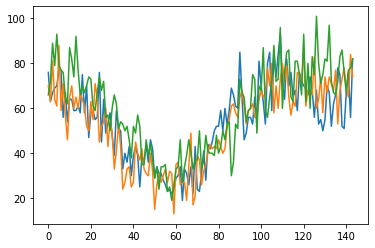

In [47]:
date = 20090601

plot_histogram(dates_dict[date+100])
plot_histogram(dates_dict[date+101])
plot_histogram(dates_dict[date+102])
plt.show()

### Experiments ( it may more than an hour)

In [48]:
D = 20
dt = 0.01
alphas = [3,6,9,12]
epsilons = [Fraction(1,100), Fraction(80,100)]

### Experiments for $\alpha = 3$

In [ ]:
y_LAS = {}
y_AVR = []
y_OA  = []
alpha = alphas[0] # = 3
for epsilon in epsilons:
    y_LAS[epsilon]=[]

for i in range(0,num_of_days-1, 1):
    print("day=", i+1)
    previous_day = dates_lst[i]
    today = dates_lst[i+1]
    J_pred = create_input(dates_dict[previous_day], D)
    J_true = create_input(dates_dict[today], D)
    
    AVR = AVR_energy_ratio(J_true, alpha)
    OA = OA_energy_ratio(J_true, alpha)
    print("AVG= ",AVR)
    y_AVR.append(AVR)
    print("OA= ",OA)
    y_OA.append(OA)
    

    for epsilon in epsilons:
        LAS_scheduling = LAS_energy_ratio(J_true, J_pred, epsilon, alpha, dt)
        print("LAS, $\epsilon$=", epsilon, "-->", LAS_scheduling)
        y_LAS[epsilon].append(LAS_scheduling)
    print("========")

day= 1
AVG=  1.4824002000840508
OA=  1.3782932094232627
LAS, $\epsilon$= 1/100 --> 1.229374937227341
LAS, $\epsilon$= 4/5 --> 1.2573794555025257
day= 2
AVG=  1.513920856429493
OA=  1.424085236073388
LAS, $\epsilon$= 1/100 --> 1.1851689543771335
LAS, $\epsilon$= 4/5 --> 1.2218032618216266
day= 3
AVG=  1.518574065440833
OA=  1.3258713296751432
LAS, $\epsilon$= 1/100 --> 1.1397062289218842
LAS, $\epsilon$= 4/5 --> 1.1818068209067762
day= 4
AVG=  1.4844515510099394
OA=  1.331386570653595
LAS, $\epsilon$= 1/100 --> 1.0679410265435376
LAS, $\epsilon$= 4/5 --> 1.0812228194856552
day= 5
AVG=  1.6921359069589235
OA=  1.392700926628663
LAS, $\epsilon$= 1/100 --> 1.1574261636139307
LAS, $\epsilon$= 4/5 --> 1.1485673168965755
day= 6
AVG=  1.7241619383316547
OA=  1.4012695766561636
LAS, $\epsilon$= 1/100 --> 1.1652478371958066
LAS, $\epsilon$= 4/5 --> 1.1422484716415275
day= 7
AVG=  1.5975930244324712
OA=  1.3260716137531718
LAS, $\epsilon$= 1/100 --> 1.334524791972887
LAS, $\epsilon$= 4/5 --> 1.36

AVG=  1.5244089519674997
OA=  1.3633242573016675
LAS, $\epsilon$= 1/100 --> 1.0982063114075247
LAS, $\epsilon$= 4/5 --> 1.1025048251870024
day= 55
AVG=  1.545354261836526
OA=  1.3614927414654114
LAS, $\epsilon$= 1/100 --> 1.0782867121027957
LAS, $\epsilon$= 4/5 --> 1.105209790614887
day= 56
AVG=  1.6406534837127442
OA=  1.3466052629345517
LAS, $\epsilon$= 1/100 --> 1.0925485682596765
LAS, $\epsilon$= 4/5 --> 1.1122196902889272
day= 57
AVG=  1.6322163135546621
OA=  1.3947771297505742
LAS, $\epsilon$= 1/100 --> 1.1270847487484763
LAS, $\epsilon$= 4/5 --> 1.1177841676753508
day= 58
AVG=  1.6853681417650235
OA=  1.4196861276999433
LAS, $\epsilon$= 1/100 --> 1.1314237081254916
LAS, $\epsilon$= 4/5 --> 1.139031423512718
day= 59
AVG=  1.4625273561272785
OA=  1.323498328899701
LAS, $\epsilon$= 1/100 --> 1.1843585528304819
LAS, $\epsilon$= 4/5 --> 1.2030526275680604
day= 60
AVG=  1.4787856536662396
OA=  1.3304509549187058
LAS, $\epsilon$= 1/100 --> 1.0843166027810613
LAS, $\epsilon$= 4/5 --> 1.

AVG=  1.648638478301944
OA=  1.3873376337916
LAS, $\epsilon$= 1/100 --> 1.128248871520856
LAS, $\epsilon$= 4/5 --> 1.1314214627708747
day= 108
AVG=  1.4866191054221425
OA=  1.3385000512089726
LAS, $\epsilon$= 1/100 --> 1.1787282330179867
LAS, $\epsilon$= 4/5 --> 1.1867634142830124
day= 109
AVG=  1.478269525572508
OA=  1.3056978911507005
LAS, $\epsilon$= 1/100 --> 1.0572499471738646
LAS, $\epsilon$= 4/5 --> 1.070980017978187
day= 110
AVG=  1.4921831023942855
OA=  1.3366629206237486
LAS, $\epsilon$= 1/100 --> 1.066579981858004
LAS, $\epsilon$= 4/5 --> 1.0731155477929526
day= 111
AVG=  1.4698264254644147
OA=  1.3331166827081784
LAS, $\epsilon$= 1/100 --> 1.0658756668930656
LAS, $\epsilon$= 4/5 --> 1.083954188020211
day= 112
AVG=  1.4471536948444055
OA=  1.2929017465939978
LAS, $\epsilon$= 1/100 --> 1.0719072080630907
LAS, $\epsilon$= 4/5 --> 1.083699288976906
day= 113
AVG=  1.6316423012925563
OA=  1.3901527353771526
LAS, $\epsilon$= 1/100 --> 1.1619445514400202
LAS, $\epsilon$= 4/5 --> 1.

LAS, $\epsilon$= 4/5 --> 1.1219691181659779
day= 160
AVG=  1.6631618481112844
OA=  1.4513579549325795
LAS, $\epsilon$= 1/100 --> 1.0979266562572672
LAS, $\epsilon$= 4/5 --> 1.1123276130866613
day= 161
AVG=  1.388319326862371
OA=  1.279783681563374
LAS, $\epsilon$= 1/100 --> 1.2468375992140017
LAS, $\epsilon$= 4/5 --> 1.2242011092829823
day= 162
AVG=  1.4673267872634237
OA=  1.412737363969148
LAS, $\epsilon$= 1/100 --> 1.2391689029515924
LAS, $\epsilon$= 4/5 --> 1.278455096025793
day= 163
AVG=  1.4038206103864068
OA=  1.254399605637856
LAS, $\epsilon$= 1/100 --> 1.1755884003555095
LAS, $\epsilon$= 4/5 --> 1.1917767235783243
day= 164
AVG=  1.4496227269193804
OA=  1.280172308528733
LAS, $\epsilon$= 1/100 --> 1.0641872790980262
LAS, $\epsilon$= 4/5 --> 1.065850138223587
day= 165
AVG=  1.4468304860350203
OA=  1.3221751345702648
LAS, $\epsilon$= 1/100 --> 1.048385033002607
LAS, $\epsilon$= 4/5 --> 1.0613968071277162
day= 166
AVG=  1.5734341298640426
OA=  1.413726995285455
LAS, $\epsilon$= 1/

LAS, $\epsilon$= 1/100 --> 1.05929453151321
LAS, $\epsilon$= 4/5 --> 1.0666972480310188
day= 213
AVG=  1.5692163688233705
OA=  1.3561210083141195
LAS, $\epsilon$= 1/100 --> 1.0670394481745669
LAS, $\epsilon$= 4/5 --> 1.0811315293171802
day= 214
AVG=  1.6120690258684511
OA=  1.3708313047040548
LAS, $\epsilon$= 1/100 --> 1.084052081530108
LAS, $\epsilon$= 4/5 --> 1.0854315041189666
day= 215
AVG=  1.3747178300406844
OA=  1.2527177257145414
LAS, $\epsilon$= 1/100 --> 1.1890913025523382
LAS, $\epsilon$= 4/5 --> 1.177813416135059
day= 216
AVG=  1.4748264896460068
OA=  1.2901498713203443
LAS, $\epsilon$= 1/100 --> 1.0731571707186753
LAS, $\epsilon$= 4/5 --> 1.0941984827321543
day= 217
AVG=  1.4425961660440236
OA=  1.264176052271398
LAS, $\epsilon$= 1/100 --> 1.0899666327642727
LAS, $\epsilon$= 4/5 --> 1.0669784205660573
day= 218
AVG=  1.4612503591402188
OA=  1.287858515118464
LAS, $\epsilon$= 1/100 --> 1.0442015538930998
LAS, $\epsilon$= 4/5 --> 1.0612659454008142
day= 219
AVG=  1.60859402408

AVG=  1.3933615438612195
OA=  1.2425740195717452
LAS, $\epsilon$= 1/100 --> 1.0461717177981265
LAS, $\epsilon$= 4/5 --> 1.0547061428333524
day= 266
AVG=  1.4017001519677585
OA=  1.2578073111053698
LAS, $\epsilon$= 1/100 --> 1.046541497846205
LAS, $\epsilon$= 4/5 --> 1.0568579927613542
day= 267
AVG=  1.387885165348353
OA=  1.2470308679001345
LAS, $\epsilon$= 1/100 --> 1.0330853983956982
LAS, $\epsilon$= 4/5 --> 1.0446731170926487
day= 268
AVG=  1.4716679712318723
OA=  1.307588733469905
LAS, $\epsilon$= 1/100 --> 1.082592262222012
LAS, $\epsilon$= 4/5 --> 1.0963603877924442
day= 269
AVG=  1.5554806273430954
OA=  1.3317255509654922
LAS, $\epsilon$= 1/100 --> 1.0641420640348989
LAS, $\epsilon$= 4/5 --> 1.0637164589881352
day= 270
AVG=  1.3965965137390646
OA=  1.2544132756338047
LAS, $\epsilon$= 1/100 --> 1.2058174819775676
LAS, $\epsilon$= 4/5 --> 1.190558310313453
day= 271
AVG=  1.3395322829550993
OA=  1.2167923553816007
LAS, $\epsilon$= 1/100 --> 1.0437540190254286


### Statistics for $\alpha = 3$

In [ ]:
print("AVR has a mean competitive ratio of :", mean(y_AVR))
print("the worst competitive ratio of AVR is :", max(y_AVR))
print("=======")
print("Optimal Available has a mean competitive ratio of :", mean(y_OA))
print("the worst competitive ratio of Optimal Available is :", max(y_OA))

print("=======")
print("Statistics for the LAS algorithm")
epsilon = Fraction(1,100)
print("EPSILON = 1/100")
the_max = max(y_LAS[epsilon])
the_mean = mean(y_LAS[epsilon])
print("the mean competitive ratio is :", the_mean)
print("the worst competitive ration is :", the_max)
print("========")
epsilon = Fraction(80,100)
print("EPSILON = 8/10")
the_max = max(y_LAS[epsilon])
the_mean = mean(y_LAS[epsilon])
print("the mean competitive ratio is :", the_mean)
print("the worst competitive ration is :", the_max)

### Experiments for $\alpha = 6$

In [ ]:
y_LAS = {}
y_AVR = []
y_OA  = []
alpha = alphas[1] # = 6
for epsilon in epsilons:
    y_LAS[epsilon]=[]

for i in range(0,num_of_days-1, 1):
    print("day=", i+1)
    previous_day = dates_lst[i]
    today = dates_lst[i+1]
    J_pred = create_input(dates_dict[previous_day], D)
    J_true = create_input(dates_dict[today], D)
    
    AVR = AVR_energy_ratio(J_true, alpha)
    OA = OA_energy_ratio(J_true, alpha)
    print("AVG= ",AVR)
    y_AVR.append(AVR)
    print("OA= ",OA)
    y_OA.append(OA)
    

    for epsilon in epsilons:
        LAS_scheduling = LAS_energy_ratio(J_true, J_pred, epsilon, alpha, dt)
        print("LAS, $\epsilon$=", epsilon, "-->", LAS_scheduling)
        y_LAS[epsilon].append(LAS_scheduling)
    print("========")

### Statistics for $\alpha = 6$

In [ ]:
print("AVR has a mean competitive ratio of :", mean(y_AVR))
print("the worst competitive ratio of AVR is :", max(y_AVR))
print("=======")
print("Optimal Available has a mean competitive ratio of :", mean(y_OA))
print("the worst competitive ratio of Optimal Available is :", max(y_OA))

print("=======")
print("Statistics for the LAS algorithm")
epsilon = Fraction(1,100)
print("EPSILON = 1/100")
the_max = max(y_LAS[epsilon])
the_mean = mean(y_LAS[epsilon])
print("the mean competitive ratio is :", the_mean)
print("the worst competitive ration is :", the_max)
print("========")
epsilon = Fraction(80,100)
print("EPSILON = 8/10")
the_max = max(y_LAS[epsilon])
the_mean = mean(y_LAS[epsilon])
print("the mean competitive ratio is :", the_mean)
print("the worst competitive ration is :", the_max)

### Experiments for $\alpha = 9$

In [ ]:
y_LAS = {}
y_AVR = []
y_OA  = []
alpha = alphas[2] #=9
for epsilon in epsilons:
    y_LAS[epsilon]=[]

for i in range(0,num_of_days-1, 1):
    print("day=", i+1)
    previous_day = dates_lst[i]
    today = dates_lst[i+1]
    J_pred = create_input(dates_dict[previous_day], D)
    J_true = create_input(dates_dict[today], D)
    
    AVR = AVR_energy_ratio(J_true, alpha)
    OA = OA_energy_ratio(J_true, alpha)
    print("AVG= ",AVR)
    y_AVR.append(AVR)
    print("OA= ",OA)
    y_OA.append(OA)
    

    for epsilon in epsilons:
        LAS_scheduling = LAS_energy_ratio(J_true, J_pred, epsilon, alpha, dt)
        print("LAS, $\epsilon$=", epsilon, "-->", LAS_scheduling)
        y_LAS[epsilon].append(LAS_scheduling)
    print("========")

### Statistics for $\alpha = 9$

In [ ]:
print("AVR has a mean competitive ratio of :", mean(y_AVR))
print("the worst competitive ratio of AVR is :", max(y_AVR))
print("=======")
print("Optimal Available has a mean competitive ratio of :", mean(y_OA))
print("the worst competitive ratio of Optimal Available is :", max(y_OA))

print("=======")
print("Statistics for the LAS algorithm")
epsilon = Fraction(1,100)
print("EPSILON = 1/100")
the_max = max(y_LAS[epsilon])
the_mean = mean(y_LAS[epsilon])
print("the mean competitive ratio is :", the_mean)
print("the worst competitive ration is :", the_max)
print("========")
epsilon = Fraction(80,100)
print("EPSILON = 8/10")
the_max = max(y_LAS[epsilon])
the_mean = mean(y_LAS[epsilon])
print("the mean competitive ratio is :", the_mean)
print("the worst competitive ration is :", the_max)

### Experiments for $\alpha = 12$

In [ ]:
y_LAS = {}
y_AVR = []
y_OA  = []
alpha = alphas[3] #=12
for epsilon in epsilons:
    y_LAS[epsilon]=[]

for i in range(0,num_of_days-1, 1):
    print("day=", i+1)
    previous_day = dates_lst[i]
    today = dates_lst[i+1]
    J_pred = create_input(dates_dict[previous_day], D)
    J_true = create_input(dates_dict[today], D)
    
    AVR = AVR_energy_ratio(J_true, alpha)
    OA = OA_energy_ratio(J_true, alpha)
    print("AVG= ",AVR)
    y_AVR.append(AVR)
    print("OA= ",OA)
    y_OA.append(OA)
    

    for epsilon in epsilons:
        LAS_scheduling = LAS_energy_ratio(J_true, J_pred, epsilon, alpha, dt)
        print("LAS, $\epsilon$=", epsilon, "-->", LAS_scheduling)
        y_LAS[epsilon].append(LAS_scheduling)
    print("========")

### Statistics for $\alpha = 12$

In [ ]:
print("AVR has a mean competitive ratio of :", mean(y_AVR))
print("the worst competitive ratio of AVR is :", max(y_AVR))
print("=======")
print("Optimal Available has a mean competitive ratio of :", mean(y_OA))
print("the worst competitive ratio of Optimal Available is :", max(y_OA))

print("=======")
print("Statistics for the LAS algorithm")
epsilon = Fraction(1,100)
print("EPSILON = 1/100")
the_max = max(y_LAS[epsilon])
the_mean = mean(y_LAS[epsilon])
print("the mean competitive ratio is :", the_mean)
print("the worst competitive ration is :", the_max)
print("========")
epsilon = Fraction(80,100)
print("EPSILON = 8/10")
the_max = max(y_LAS[epsilon])
the_mean = mean(y_LAS[epsilon])
print("the mean competitive ratio is :", the_mean)
print("the worst competitive ration is :", the_max)